<a href="https://colab.research.google.com/github/ParthikB/Neural-Style-Transfer/blob/master/main_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Uncomment the following code to mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
%tensorflow_version 1.15.0 # Defining which Tf version to use
import tensorflow as tf
import keras.backend as K
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.python.keras import models
from keras.models import Model
from keras.preprocessing import image

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os
import urllib
import statistics
from tqdm import tqdm_notebook as tqdm

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15.0 # Defining which Tf version to use`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
# Enabling Eager Execution
tf.enable_eager_execution()
print("Eager Execution Initialized:",tf.executing_eagerly())

Eager Execution Initialized: True


# Helper Functions

### Selecting the Feature Layers needed

In [0]:
# Defining the Feature Layers we need respectively
styleLayers = ['block1_conv2', 
               'block2_conv2', 
               'block3_conv3', 
               'block4_conv3', 
               'block5_conv3']

contentLayer = ['block3_conv2']


numContentLayers = len(contentLayer) # Number of Content Layers
numStyleLayers   = len(styleLayers)  # Number of Style Layers

In [0]:
# Defining Function to import model (VGG19)
def getModel():

  # Loading Model from tf
  model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  model.trainable = False # Freezing to parameters

  # Features of the Respective Layers
  contentFeatures = [model.get_layer(name).output for name in contentLayer]
  styleFeatures   = [model.get_layer(name).output for name in styleLayers]
  
  modelOutput = contentFeatures + styleFeatures

  return models.Model(model.input, modelOutput)

In [0]:
# Defining GRAM MATRIX
def gram(x):

  # number of channels
  channels = int(x.shape[-1])
  
  # reshaping to channel first
  a = tf.reshape(x, [-1, channels])
  n = tf.shape(a)[0]
  
  # gram matrix
  gram = tf.matmul(a, a, transpose_a=True)
  
  return gram / tf.cast(n, tf.float32)


# Defining CONTENT COST
def contentCost(contentFeatures, generateFeatures):
  return tf.reduce_mean(tf.square(contentFeatures-generateFeatures))


# Defining STYLE COST
def styleCost(styleFeatures, generateFeatures):
  styleGram = gram(styleFeatures)
  return tf.reduce_mean(tf.square(styleGram - generateFeatures))

### Image Manipulations

In [0]:
"""
  Helper function to compute our content and style feature representations.
 
  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """

def getFeatures(content, style, model):
  
  # Defining the respective outputs from our model
  contentOutputs = model(content)
  styleOutputs = model(style)
  
  # Extracting out the different features from the model output
  contentFeatures = [contentFeature[0] for contentFeature in contentOutputs[numStyleLayers:]]
  styleFeatures = [styleFeature[0] for styleFeature in styleOutputs[:numStyleLayers]]

  return contentFeatures, styleFeatures


def loadImage(path_to_img):
  max_dim = 512
  img2show = Image.open(path_to_img)
  long = max(img2show.size)
  scale = max_dim/long
  img = img2show.resize((round(img2show.size[0]*scale), round(img2show.size[1]*scale)), Image.ANTIALIAS)
  
  img = image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img2show, axis=0)
  return img2show, img
 

def urlToImage(url):
  resp = urllib.request.urlopen(url)
  img = np.asarray(bytearray(resp.read()), dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  img2show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = np.expand_dims(img2show, axis=0)
  return img2show, img
 

def inputImageAndPreprocess(path):
  # Loading the image and reshaping it according to VGG19 requirements.
  if path[:4]=='http':
    # print("Loading Image from Internet...")
    img2show, img = urlToImage(path)
  else:
    # print("Loading Image from Local...")
    img2show, img = loadImage(path)
  
  # Preprocessing the img according to VGG19 requirements
  img = tf.keras.applications.vgg19.preprocess_input(img)

  return img2show, img


# Deprocessing Image to save locally
def deprocessImage(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Computing the total Loss

In [0]:
def totalLoss(model, lossWeights, generateImage, contentFeatures, styleFeatures):

  # Extracting the respective weights
  contentWeight, styleWeight = lossWeights

  # Extracting the generate image features from the model
  modelOutputs = model(generateImage)

  # Splitting the generate Features into different categories
  contentGenerateFeatures = modelOutputs[numStyleLayers:]
  styleGenerateFeatures   = modelOutputs[:numStyleLayers]

  # Initializing all costs with 0
  contentCostValue, styleCostValue = 0, 0

  # Defining partial weights
  contentWeightPerLayer = 1.0 / float(numContentLayers)
  styleWeightPerLayer = 1.0 / float(numStyleLayers)

  # Computing Content Cost
  for generateContent, combinationContent in zip(contentFeatures, contentGenerateFeatures):
    contentCostValue += contentWeightPerLayer * contentCost(combinationContent[0], generateContent)

  # Computing Style Cost for every layer
  for generateStyle, combinationStyle in zip(styleFeatures, styleGenerateFeatures):
    styleCostValue += styleWeightPerLayer * styleCost(combinationStyle[0], generateStyle)
  

  # Assigning the weights
  contentCostValue *= contentWeight
  styleCostValue *= styleWeight

  # Computing the Total Loss
  totalLossValue = contentCostValue + styleCostValue

  return totalLossValue, contentCostValue, styleCostValue

### Computing the Gradient Descent

In [0]:
def computeGrads(config):
  with tf.GradientTape() as tape:
    allLoss = totalLoss(**config)

  loss = allLoss[0]

  return tape.gradient(loss, config['generateImage']), allLoss

In [11]:
"""
FUNTIONS DEFINED SO FAR:

  > getModel()
  > gram()
  > contentCost()
  > styleCost()
  > getFeatures()
  > load_img()
  > inputImageAndPreprocess()
  > totalLoss()
  > computeGrads()

"""

'\nFUNTIONS DEFINED SO FAR:\n\n  > getModel()\n  > gram()\n  > contentCost()\n  > styleCost()\n  > getFeatures()\n  > load_img()\n  > inputImageAndPreprocess()\n  > totalLoss()\n  > computeGrads()\n\n'

### Time to get it all together

In [0]:
# Defining the MAIN TRAINING FUNCTION
def runStyleTransfer(contentPath,
                     stylePath,
                     iterations     = 1000,
                     SAVE_EVERY     = 0,
                     contentWeight  = 1e3,
                     styleWeight    = 1e-2,
                     output_dirName = None):
    
  # Importing the Model
  model = getModel()
  for layer in model.layers:
    layer.trainable = False

  if type(contentPath) == str:
    _ , contentImage = inputImageAndPreprocess(contentPath)
  else:
    contentImage = contentPath
    
  _ ,     styleImage = inputImageAndPreprocess(stylePath)
  
  # Extracting out the respective features from the model
  contentFeatures, styleFeatures = getFeatures(contentImage, styleImage, model)
  styleFeatures = [gram(styleFeature) for styleFeature in styleFeatures]

  # Creating the Generate Image
  generateImage = contentImage
  generateImage = tf.Variable(generateImage, dtype=tf.float32)

  # Defining the Adam Optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate=5, epsilon=1e-3)

  # Storing the best Image and Loss
  bestLoss, bestImage = float('inf'), None

  # Zipping the Weights
  lossWeights = (contentWeight, styleWeight)
  
  # Defining the Config File
  config = {
    'model': model,
    'lossWeights': lossWeights,
    'generateImage': generateImage,
    'contentFeatures': contentFeatures,
    'styleFeatures': styleFeatures
    }
  
  globalStart = time.time()
  
  normMeans = np.array([103.939, 116.779, 123.68])
  minVals = -normMeans
  maxVals = 255 - normMeans  

  # Creating Logs to use for Plotting Later
  contentCostLog, styleCostLog, totalCostLog = [], [], []

  ETA = 0
  timeLog = []
  if output_dirName:
    PATH = f'/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output/vids/{output_dirName}'
    if not os.path.isdir(PATH):
      os.mkdir(PATH)
    os.chdir(PATH)

  for iter in tqdm(range(iterations), leave=False):
    startTime = time.time()

    # Computing the Grads and Loss
    grads, allLoss = computeGrads(config)

    # Extracting different kinds of Losses
    loss, contentLoss, styleLoss = allLoss
    
    # Saving the respective losses in respective lists for plotting
    contentCostLog.append(contentLoss)
    styleCostLog.append(styleLoss)
    totalCostLog.append(loss)

    # Applying gradients to Generate Image
    optimizer.apply_gradients([(grads, generateImage)])

    # Clipping the values of Generate Image from (-255, 255)
    clipped = tf.clip_by_value(generateImage, minVals, maxVals)
    generateImage.assign(clipped)

    endTime = time.time()

    timeTakenbyOneImage = endTime - startTime
    timeLog.append(timeTakenbyOneImage)

    ETA = statistics.mean(timeLog) * (iterations-iter)

    # Updating the Best Image and Loss
    if loss < bestLoss:
      bestLoss = loss
      bestImage = generateImage.numpy()

    # Saving the Generate Image
    if SAVE_EVERY:
      if iter % SAVE_EVERY == 0:
        new = cv2.cvtColor(deprocessImage(generateImage.numpy()), cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'generateImage_{iter+1}.jpg', new)

      # print(f"Image {iter+1} Saved || Time Taken: {round(timeTakenbyOneImage, 2)} sec || ETA: {round(ETA/60, 2)} min" )
    
  if not SAVE_EVERY:
    new = cv2.cvtColor(deprocessImage(generateImage.numpy()), cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'generateImage_{iter}.jpg', new)
  else:
    # Saving the numpy Arrays to plot later
    np.save('contentLoss.npy', contentCostLog)
    np.save('styleLoss.npy', styleCostLog)
    np.save('totalCostLoss.npy', totalCostLog)

  # print('Total Time taken in training :', round(endTime-globalStart, 2))

  return bestImage, bestLoss, output_dirName


## Visualizing our Content And Style Images

Text(0.5, 1.0, 'Style Image')

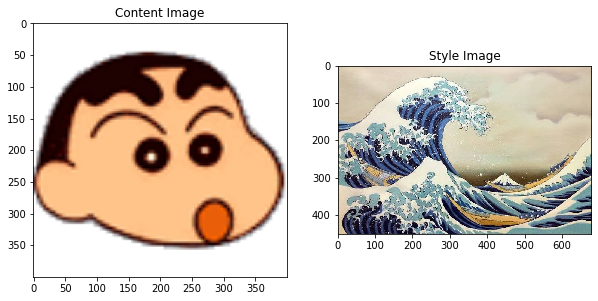

In [64]:
# Style Templates:
wave = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ8LOCDfTvcJ_V4fBdtL3R_oQn7D9P96PPzJFCksdWeKHHhyfUZ'
seated_nude = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ0ip7KMW5XB_qhU3cwBDDd1fjlogHfgOxw9gnVq2CqZdLwHgY3'
shinchan = 'https://pbs.twimg.com/profile_images/452516792426975232/rOQPTVq4_400x400.png'

# PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/vids/surf/'

# Enter the path of the respective Images
contentImagePath = shinchan
styleImagePath   = wave

content, _ = inputImageAndPreprocess(contentImagePath)
style, _   = inputImageAndPreprocess(styleImagePath)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

# **Training**

In [70]:
ITERATIONS = 10
DIR_NAME   = 'shinchan'


bestImage, bestLoss, output_dirName = runStyleTransfer(contentImagePath,
                                                      styleImagePath,
                                                      iterations=ITERATIONS,
                                                      SAVE_EVERY = 0,
                                                      contentWeight = 1,
                                                      styleWeight= 0.8,)
                                                      # output_dirName = DIR_NAME)

# Output Cleared for Fairness

<class 'str'>


#### Visualizing the Best Image

Text(0.5, 1.0, 'Generated Image')

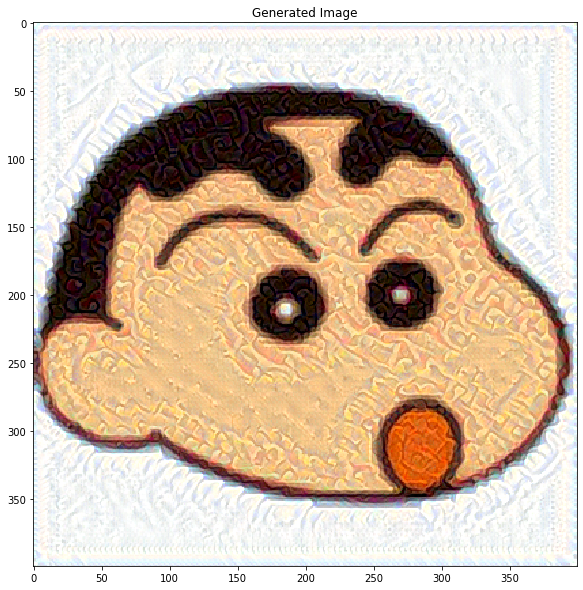

In [71]:
plt.figure(figsize=(10,10))
plt.imshow(deprocessImage(bestImage))
plt.title('Generated Image')

#### Plotting the Cost Functions

In [16]:
PATH = f'/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output/{output_dirName}'
os.chdir(PATH)
contentLog = np.load('contentLoss.npy')
print('Content Log Loaded..!')
styleLog = np.load('styleLoss.npy')
print('Style Log Loaded..!')
totalLog = np.load('totalCostLoss.npy')
print('Total Loss Log Loaded..!')
iterations = list(range(1, len(styleLog)+1))

FileNotFoundError: ignored

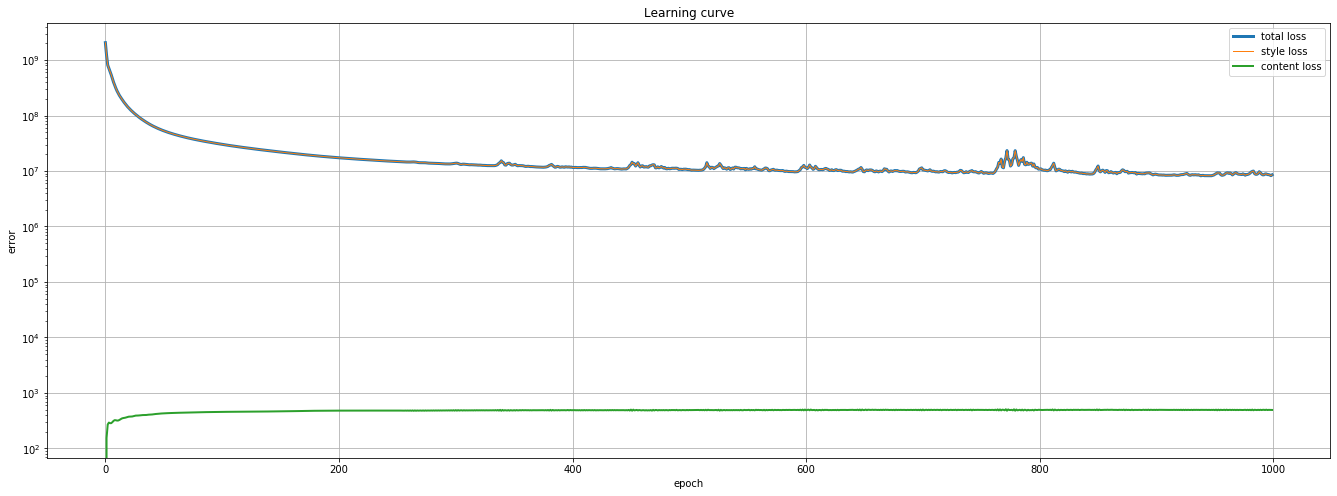

In [0]:
plt.figure(figsize=(23, 8))
plt.plot(totalLog,   linewidth=3, label='total loss')
plt.plot(styleLog,   linewidth=1, label='style loss')
plt.plot(contentLog, linewidth=2, label='content loss')
# plt.plot(learning_curve_tv, linewidth=2, label='total variation loss')
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/vids/surf/'
frame = 1 

master = []
dir = os.listdir(PATH)
for f in dir:
  fnum = int(f[13:])
  master.append([fnum, f])

for f in sorted(master):
  ITERATIONS = 500
  contentImagePath = PATH + f
  styleImagePath   = wave
  
  print(f"Processing Frame : {frame}")

  bestImage, bestLoss, output_dirName = runStyleTransfer(contentImagePath,
                                                        styleImagePath,
                                                        iterations=ITERATIONS,
                                                        SAVE_EVERY = None,
                                                        contentWeight = 1,
                                                        styleWeight= 0.8,
                                                        output_dirName = 'surfer_' + f'frame_{frame}')
  frame += 1

In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/vids/surf/'
os.listdir(PATH)

In [0]:
import shutil

ROOT_PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output/vids/'

# Little jugaad code to sort the frames and create a list -- master
master = []
dir = os.listdir(ROOT_PATH)
for f in dir:
  fnum = int(f[13:])
  master.append([fnum, f])

# Creating array to append the cv2.imread(frame)
img_arr = []
dest_path = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output/surfer/'

# Appending the frame from their respective folder to img_arr
FRAME = 0
for _, sub_dir in sorted(master):
  FRAME += 1
  # print(sub_dir)
  src = ROOT_PATH + sub_dir
  # os.chdir(temp_dir_path)
  for fname in (os.listdir(src)):
    if fname=='generateImage_499.jpg':
      src = os.path.join(src, fname)
      shutil.copyfile(src, dest_path+str(FRAME)+'.jpg')
      # os.chdir(dest_path)
      # os.rename('generateImage_499.jpg', FRAME+'.jpg')
  #     img = cv2.imread(fname)
  #     img_arr.append(img)

  # height, width, channels = img.shape
  # size = (width,height)

  

# for filename in glob.glob('C:/New folder/Images/*.jpg'):
#     img = cv2.imread(filename)
#     height, width, layers = img.shape
#     size = (width,height)
#     img_array.append(img)
 
 
# out = cv2.VideoWriter('/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output/vids/project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
# print('Developing the Video')
# for i in (range(len(img_array))):
#     out.write(img_array[i])
# out.release()

In [0]:
len(img_arr)

51

In [0]:
vid_path = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/vids/surf.mp4'

def extract_frames_out_of_the_video(vid_path):
  cam = cv2.VideoCapture(vid_path)

  currentframe = 1
  frames = []

  while(True): 
        
      # reading from frame 
      ret, frame = cam.read() 
    
      if ret:
          frames.append(frame)
          print(currentframe, end='\r') 
          # # if video is still left continue creating images 
          # PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/vids/surf/'
          # fname = 'frame_' + str(currentframe) + '.jpg'
          # name = PATH + fname
          # # print ('Creating...' + fname) 
    
          # # writing the extracted images 
          # if currentframe % 1 == 0:
          #   print(f'Saving {fname}')
          #   cv2.imwrite(name, frame) 
    
          # # increasing counter so that it will 
          # # show how many frames are created 
          currentframe += 1
      else: 
          break
  print('Frames generated..!')
  return frames

In [26]:
vid_frames = extract_frames_out_of_the_video(vid_path)

Frames generated..!


In [0]:
#@title Parameters:
Video_path = "/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/vids/surf.mp4" #@param {type:"string"}

Output_quality = "Just show me the thing already" #@param ["Super Duper", "Fancier than Average", "Ya ok Whatever", "Just show me the thing already"]


if Output_quality == 'Super Duper':
  skip_frame_every = 1
elif Output_quality == 'Fancier than Average':
  skip_frame_every = 3
elif Output_quality == 'Ya ok Whatever':
  skip_frame_every = 6
else:
  skip_frame_every = 10

In [75]:
ITERATIONS = 100
OUTPUT_DIR = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output/vids/'
OUTPUT_FILE_NAME = 'complete'
generated_frames = []

for frame_number in tqdm(range(0, len(vid_frames), skip_frame_every)):

  content = vid_frames[frame_number]

  bestImage, bestLoss, output_dirName = runStyleTransfer(content,
                                                        styleImagePath,
                                                        iterations=ITERATIONS,
                                                        contentWeight = 1,
                                                        styleWeight= 0.8)
  generated_frames.append(bestImage)
  height, width, channels = bestImage.shape


print('Developing the Video')
out = cv2.VideoWriter(OUTPUT_DIR + OUTPUT_FILE_NAME + '.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))
for i in (range(len(img_array))):
    out.write(img_array[i])
out.release()

ValueError: ignored